# Comparación DT en R y en Python

En este notebook compararé el comportamiento del modelo DecisionTree de R con el de Python, para ver si descrepan.

Iré modificando los parámetros que cada uno tiene, y veremos el accuracy que consigue cada uno

https://www.kaggle.com/pitasr/falldata

In [1]:
sos_path = "../../datasets/falldetection/falldetection.csv"

## En python3

In [2]:
%use python3

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
df = pd.read_csv(sos_path)

In [3]:
N = df.shape[0]
prop_train = 2 / 3
N_train = np.ceil(N * prop_train).astype(np.int64)
N_test = N - N_train

In [4]:
data = df.drop(["ACTIVITY"], 1)
target = df.ACTIVITY

In [5]:
data_train = data.iloc[:N_train]
data_test = data.iloc[N_train:]

target_train = target[:N_train]
target_test = target[N_train:]

In [6]:
dtc = DecisionTreeClassifier()

In [7]:
dtc.fit(data_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
train_score = dtc.score(data_train, target_train)
test_score = dtc.score(data_test, target_test)

In [9]:
train_score, test_score

(1.0, 0.6915750915750916)

## En R

In [10]:
%use R
library(rpart)
df = read.csv(sos_path)

In [11]:
df$ACTIVITY = as.factor(df$ACTIVITY)

In [12]:
N = nrow(df)
prop_train = 2/3
N_train = ceiling(N * prop_train)
N_test = N - N_train
data_train = df[1:N_train,]
data_test = df[(N_train + 1):N,]

In [13]:
ctrl = rpart.control(
    minsplit = 2,
    cp = 0,
    maxcomplete = 0,
    maxsurrogate = 0,
    usesurrogate = 0,
    xval = 10,
    surrogatestyle = 0,
    maxdepth = 30,
)

In [14]:
rpt = rpart(ACTIVITY ~ ., data = data_train,control = ctrl, method = "class")

In [15]:
train_pred = predict(rpt, data_train, type = "class")
test_pred = predict(rpt, data_test, type = "class")

In [16]:
train_cf = table(data_train$ACTIVITY, train_pred)
test_cf = table(data_test$ACTIVITY, test_pred)

In [17]:
R_train_score = sum(diag(train_cf)) / nrow(data_train)
R_test_score = sum(diag(test_cf)) / nrow(data_test)

In [18]:
R_train_score

[1] 1

In [19]:
R_test_score

[1] 0.6840659

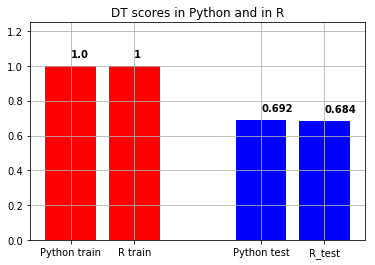

In [20]:
%get R_train_score R_test_score --from R

scores = [train_score,R_train_score, test_score,R_test_score]
labs = ["Python train", "R train", "Python test",  "R_test"]
cols = ["r","r","b","b"]
posit = [0,1,3,4]
plt.bar(x = posit,  height = scores, tick_label = labs, color = cols)
plt.grid(True)
plt.title("DT scores in Python and in R")
plt.ylim(0,1.25)
for i in range(len(scores)):
    plt.text(posit[i], scores[i] + 0.05, round(scores[i],3),fontweight='bold')
    

## Modificando min_samples_split

### En R

In [21]:
%use R
df = read.csv(sos_path)
df$ACTIVITY = as.factor(df$ACTIVITY)
N = nrow(df)
prop_train = 2/3
N_train = ceiling(N * prop_train)
N_test = N - N_train
data_train = df[1:N_train,]
data_test = df[(N_train + 1):N,]

In [22]:
spl = 2:60

In [23]:
f = function(s) 
    {
        ctrl = rpart.control(
            minsplit = s,
            cp = 0,
            maxcomplete = 0,
            maxsurrogate = 0,
            usesurrogate = 0,
            xval = 10,
            surrogatestyle = 0,
            maxdepth = 30,
        )
        rpt = rpart(ACTIVITY ~ ., data = data_train,control = ctrl, method = "class")
    
        train_pred = predict(rpt, data_train, type = "class")
        test_pred = predict(rpt, data_test, type = "class")
        
        train_cf = table(data_train$ACTIVITY, train_pred)
        test_cf = table(data_test$ACTIVITY, test_pred)
    
        R_train_score = sum(diag(train_cf)) / nrow(data_train)
        R_test_score = sum(diag(test_cf)) / nrow(data_test)
        return(list("train" = R_train_score, "test" = R_test_score))
    }

In [24]:
res = sapply(spl, FUN = "f")

In [25]:
R_train_scores = res[1, 1:ncol(res)]
R_test_scores = res[2, 1:ncol(res)]

### En Python3

In [26]:
clf = DecisionTreeClassifier()

In [27]:
python_train_scores = []
python_test_scores = []
for i in range(2,61):
    clf.set_params(min_samples_split = i)
    clf.fit(data_train, target_train)
    train_score = clf.score(data_train, target_train)
    test_score = clf.score(data_test, target_test)
    
    python_train_scores.append(train_score)
    python_test_scores.append(test_score)

Text(0, 0.5, 'Accuracy')

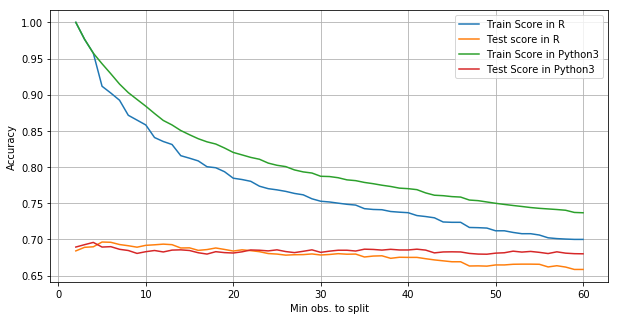

In [28]:
%get R_train_scores R_test_scores spl --from R
plt.figure(figsize=(10,5))
plt.plot(spl ,R_train_scores, label = "Train Score in R")
plt.plot(spl, R_test_scores, label = "Test score in R")
plt.plot(spl, python_train_scores, label = "Train Score in Python3")
plt.plot(spl, python_test_scores, label = "Test Score in Python3")
plt.grid(True)
plt.legend()
plt.xlabel("Min obs. to split")
plt.ylabel("Accuracy")
#plt.ylim(0.5,1.1)


## Modificando max_depth

In [29]:
%use R

df = read.csv(sos_path)

df$ACTIVITY = as.factor(df$ACTIVITY)

N = nrow(df)
prop_train = 2/3
N_train = ceiling(N * prop_train)
N_test = N - N_train

data_train = df[1:N_train,]

data_test = df[(N_train + 1):N,]

d = 2:30



In [30]:
f = function(d) {
    ctrl = rpart.control(
            minsplit = 20,
            cp = 0,
            maxcomplete = 0,
            maxsurrogate = 0,
            usesurrogate = 0,
            xval = 10,
            surrogatestyle = 0,
            maxdepth = d,
    )
    rpt = rpart(ACTIVITY ~ ., data = data_train,control = ctrl, method = "class")
    
    train_pred = predict(rpt, data_train, type = "class")
    test_pred = predict(rpt, data_test, type = "class")
        
    train_cf = table(data_train$ACTIVITY, train_pred)
    test_cf = table(data_test$ACTIVITY, test_pred)
    
    R_train_score = sum(diag(train_cf)) / nrow(data_train)
    R_test_score = sum(diag(test_cf)) / nrow(data_test)
    return(list("train" = R_train_score, "test" = R_test_score))
}

In [31]:
res = sapply(d, FUN = "f")

In [32]:
R_train_scores = res[1, 1:ncol(res)]
R_test_scores = res[2, 1:ncol(res)]

#### Nos pasamos a python

In [33]:
clf = DecisionTreeClassifier()

In [34]:
python_train_scores = []
python_test_scores = []
d = list(range(2,31))
for i in d:
    clf.set_params(max_depth = i)
    clf.fit(data_train, target_train)
    train_score = clf.score(data_train, target_train)
    test_score = clf.score(data_test, target_test)
    
    python_train_scores.append(train_score)
    python_test_scores.append(test_score)

Text(0, 0.5, 'Accuracy')

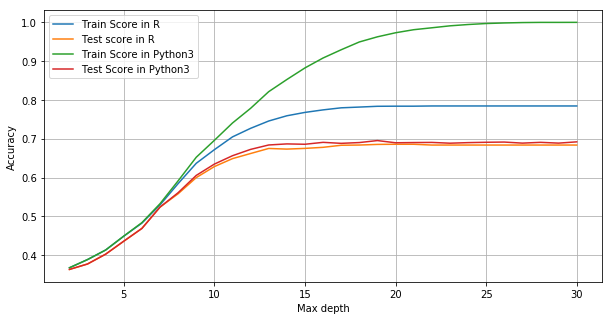

In [35]:
%get R_train_scores R_test_scores --from R
plt.figure(figsize=(10,5))
plt.plot(d ,R_train_scores, label = "Train Score in R")
plt.plot(d, R_test_scores, label = "Test score in R")
plt.plot(d, python_train_scores, label = "Train Score in Python3")
plt.plot(d, python_test_scores, label = "Test Score in Python3")
plt.grid(True)
plt.legend()
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
#plt.ylim(0.5,1.1)